<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ALL-Setting" data-toc-modified-id="ALL-Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ALL Setting</a></span><ul class="toc-item"><li><span><a href="#Colab-setting" data-toc-modified-id="Colab-setting-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Colab setting</a></span></li></ul></li><li><span><a href="#Package-import" data-toc-modified-id="Package-import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Package import</a></span></li><li><span><a href="#Load-Tokenizer-and-BERT-base" data-toc-modified-id="Load-Tokenizer-and-BERT-base-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Tokenizer and BERT-base</a></span></li><li><span><a href="#Extract-Contextual-embedding-for-Sentences" data-toc-modified-id="Extract-Contextual-embedding-for-Sentences-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract Contextual embedding for Sentences</a></span><ul class="toc-item"><li><span><a href="#choose-task" data-toc-modified-id="choose-task-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>choose task</a></span><ul class="toc-item"><li><span><a href="#For-BERT" data-toc-modified-id="For-BERT-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>For BERT</a></span></li><li><span><a href="#For-MAML" data-toc-modified-id="For-MAML-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>For MAML</a></span></li></ul></li><li><span><a href="#Loading-Pretrain-encoding" data-toc-modified-id="Loading-Pretrain-encoding-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loading Pretrain encoding</a></span></li></ul></li><li><span><a href="#Data-Split-and-Data-Loader" data-toc-modified-id="Data-Split-and-Data-Loader-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Split and Data Loader</a></span></li><li><span><a href="#Model-for-Upstream-Task" data-toc-modified-id="Model-for-Upstream-Task-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model for Upstream Task</a></span></li><li><span><a href="#Training-&amp;-Validation" data-toc-modified-id="Training-&amp;-Validation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training &amp; Validation</a></span><ul class="toc-item"><li><span><a href="#BERT-training" data-toc-modified-id="BERT-training-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>BERT training</a></span></li><li><span><a href="#MAML-training" data-toc-modified-id="MAML-training-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>MAML training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Prediction</a></span><ul class="toc-item"><li><span><a href="#decoding-and-save-text-prediction" data-toc-modified-id="decoding-and-save-text-prediction-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>decoding and save text prediction</a></span></li></ul></li></ul></div>

# ALL Setting

In [ ]:
use_colab = True
num_samples = None
model_path='/content/drive/MyDrive/Conf_Call/language_features_tuning/bert_wyang.pt'

## tokenizer setting
# batch_size = 16
# random_state = 1234
# test_size = 0.1

## model setting
num_labels, label_size = 2, 2
labels = ['0','1']
label_cols = 'label'
class_weight = [1.0,5.0]
batch_size = 64
epochs = 40
patience = 30
learning_rate = 1e-4


max_len = 50
seq_len = max_len
embed_dim = 768
hidden_units = 100
num_filters = 64
kernel_sizes = [1,3, 5]


freeze_bert = True
embed_type = 1


training_file = 'all_data_v9_all_kiera.xlsx' # by Data_Collection_for_MAML.ipynb
dtype = 'float32'

## Colab setting

# Package import

In [ ]:
import os
import sys


def down_load_packages():
    !pip install torchinfo
    !pip install transformers
    # !pip install learn2learn
    # !pip install datasets
    # !pip install pytorch
    # !pip install tqdm
    # !pip install mkl
    # !pip install sas7bdat
    # !pip install datatable
    # !pip install tensorboardX

    return None
    

def connect_colab(use_colab=True, download_package=False, cwd='/Conf_Call/code/data', data_folder=''):

    
    if use_colab is True:
        from google.colab import drive
        drive.mount('/content/drive')
        sys_path = '/content/drive/MyDrive'
        if download_package:
            down_load_packages()
    else:
        sys_path = 'E:/MyGoogleDrive'       
        
    path1 = sys_path + '/Conf_Call/code/5_emotion_extraction'
    path2 = sys_path+'/Conf_Call/code/data'
    CWD = sys_path + cwd 
    os.chdir(CWD)
    sys.path.append(path1)
    sys.path.append(path2)
    
    data_path = os.path.join(path2, data_folder)
    print('Append path: ', path1)
    print('CWD: ', os.getcwd())
    print("Data path: ", data_path)
    return CWD, data_path, sys_path

cwd, data_path, sys_path = connect_colab(use_colab=True, download_package=True, cwd='/Conf_Call/code/5_emotion_extraction/emotion_classifier', data_folder='')

data_path = os.path.join(cwd, 'data')
models_path = os.path.join(os.path.join(cwd, 'models'))
result_path = os.path.join(os.path.join(cwd, 'results'))



import pandas as pd
import numpy as np
import pickle
from glob import glob
# from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report,precision_recall_fscore_support
from sklearn.utils import shuffle
from pprint import pprint
from random import sample

import torch
from torchinfo import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW, BertConfig, get_linear_schedule_with_warmup
# , AutoModel, AutoTokenizer
# import learn2learn as l2l
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from wei_utils.data_loader import data_loading, preprocessing_for_emo_mix_balance
# from wei_utils.maml_training_utils import MAML_train, history_vis 
# from wei_utils.maml_dataloader import MAML_Data_loader, MAML_train_val_split

from bert_utils import glovar 
from bert_utils.model import  bert_lstm_cnn
from bert_utils.training_utils import *
from bert_utils.data_loader import data_loader_BERT, one_hot_encoded_y, k_fold_data_loader_BERT

setup_seed(1234)
training_dtype = torch.float16 if dtype == 'float16' else torch.float32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Append path:  /content/drive/MyDrive/Conf_Call/code/5_emotion_extraction
CWD:  /content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/emotion_classifier
Data path:  /content/drive/MyDrive/Conf_Call/code/data/
My Linux system:  Linux
using:  cuda
Append path:  /content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils
My Linux system:  Linux
using:  cuda


# Load DataSet

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Conf_Call/language_features_tuning/surprise_dt_test_v9_all_kiera.xlsx").dropna()
print(df.groupby(['label']).size())

label
0.0    1055
1.0     116
dtype: int64


In [ ]:
df = df.groupby(['label']).sample(116, replace=False)
class_weight = [1,5]
print(df.groupby(['label']).size())

label
0.0    116
1.0    116
dtype: int64


In [ ]:
sentences = df.sentence.values
labels = df.label.astype(int).values

train_text = sentences
train_one_hot_labels = one_hot_encoded_y(labels)

In [ ]:
[torch.cuda.empty_cache() for _ in range(10) ]
# print(torch.cuda.memory_summary())

[None, None, None, None, None, None, None, None, None, None]

# Load Tokenizer and Model

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
## for freeze_bert version train_sentences_encoding is the attention mask
train_input_ids, train_attention_masks = text_to_tokens(sentences, tokenizer, max_len=max_len)
dataloader, validation_dataloader = data_loader_BERT( train_input_ids, train_attention_masks, train_one_hot_labels,  batch_size, random_state=1234, test_size=0.2)

100%|██████████| 232/232 [00:00<00:00, 954.12it/s]
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.int32)
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks, dtype=torch.int32)


In [ ]:
bert_model = bert_lstm_cnn(embed_dim, max_len, hidden_units, num_filters, kernel_sizes, label_size, 
                                                freeze_bert=freeze_bert, bert_embed_type=embed_type, dropout_rate=0.1)
# global device
device = glovar.device_type
bert_model = bert_model.to(device)

print(next(bert_model.parameters()).device)  # 输出：cpu
summary(bert_model)
get_parameter_number(bert_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


{'Total': 110294018, 'Trainable': 811778}

# Training 

cuda

======== Epoch 1 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6957	 Train Acc: 0.5016	      Val Loss: 0.6959	 Val Acc: 0.4894	 Val F1: 0.0	Val ovr AUC: 0.5199


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


             best_model updated based on ovr AUC !

======== Epoch 2 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6933	 Train Acc: 0.4905	      Val Loss: 0.6949	 Val Acc: 0.4894	 Val F1: 0.0	Val ovr AUC: 0.5308


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


             best_model updated based on ovr AUC !

======== Epoch 3 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6933	 Train Acc: 0.5009	      Val Loss: 0.6937	 Val Acc: 0.4894	 Val F1: 0.0	Val ovr AUC: 0.5525


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


             best_model updated based on ovr AUC !

======== Epoch 4 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6903	 Train Acc: 0.5446	      Val Loss: 0.6925	 Val Acc: 0.5532	 Val F1: 0.2222	Val ovr AUC: 0.558
             best_model updated based on ovr AUC !

======== Epoch 5 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6888	 Train Acc: 0.5192	      Val Loss: 0.6912	 Val Acc: 0.5745	 Val F1: 0.375	Val ovr AUC: 0.5815
             best_model updated based on ovr AUC !

======== Epoch 6 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6845	 Train Acc: 0.594	      Val Loss: 0.6899	 Val Acc: 0.5957	 Val F1: 0.4865	Val ovr AUC: 0.6069
             best_model updated based on ovr AUC !

======== Epoch 7 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6858	 Train Acc: 0.6109	      Val Loss: 0.6887	 Val Acc: 0.5745	 Val F1: 0.5652	Val ovr AUC: 0.6268
             best_model updated based on ovr AUC !

======== Epoch 

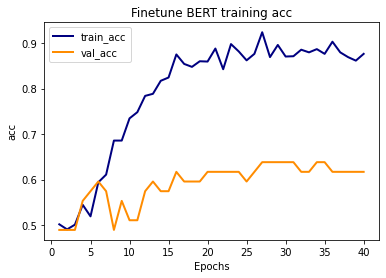

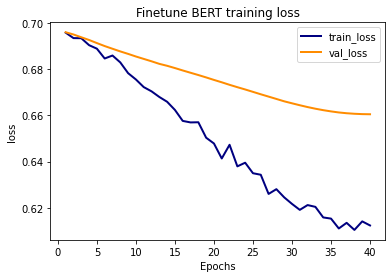

In [ ]:
# Data Loader
model = bert_model

optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

model, training_stats = fit_bert_model(model, label_size, dataloader, validation_dataloader, class_weight=class_weight,
                                                                                optimizer=optimizer, scheduler=scheduler, epochs=epochs, patience=patience, model_path=model_path)


df_stats = pd.DataFrame(data=training_stats).set_index('epoch')
df_stats.to_csv(model_path[0:-2] + 'csv')
plot_bert_history(df_stats)

# Evaluation

In [ ]:
# sentences = test_dt 
# one_hot_labels = test_dt.label 
# input_ids, attention_masks = text_to_tokens(sentences, tokenizer, max_len=max_len)
# test_dataloader, _ = data_loader_BERT( input_ids, attention_masks, one_hot_labels,  batch_size, random_state=1234, test=True)
# tokenized_texts, pred_labels, true_labels, avg_val_loss, val_acc = pred_bert_model(model, test_dataloader, num_labels, class_weight=class_weight, task='Test', verbose=2)

## K fold CV

In [ ]:
result = []
label_cols = ['label']
k_fold = 4

k_folds_training_stat = pd.DataFrame()

for col in label_cols: # for multiple columns?
    print("\n------------") 
    print(col)
    print("------------")
    
    # y = df[col].astype(int).values
    skf = StratifiedKFold(n_splits=k_fold, random_state=42, shuffle=True)
    sentences = df.sentence.values
    labels = df.label.astype(int).values
    one_hot_labels = one_hot_encoded_y(labels)

    input_ids, attention_masks = text_to_tokens(sentences, tokenizer, max_len=max_len)
    k_folds_loader = k_fold_data_loader_BERT(input_ids, attention_masks, one_hot_labels, batch_size=batch_size, random_state=1234, k_fold=k_fold)

    for k, (train_dataloader, validation_dataloader) in enumerate(k_folds_loader):

        model_cv_name =  "model_cv_kiera_" + str(k)
        model_cv = bert_lstm_cnn(embed_dim, max_len, hidden_units, num_filters, kernel_sizes, label_size, 
                                                        freeze_bert=freeze_bert, bert_embed_type=embed_type, dropout_rate=0.1)
        model_cv = model_cv.to(glovar.device_type)
        model_cv, training_stats = fit_bert_model(model, num_labels, train_dataloader, validation_dataloader, optimizer=optimizer, 
                                                  scheduler=scheduler, epochs=epochs, class_weight=class_weight, patience=patience, 
                                                  model_path=model_cv_name, verbose=0)
        fold_tr_stat = pd.DataFrame(training_stats)
        fold_tr_stat['k_fold'] = k
        k_folds_training_stat = pd.concat([fold_tr_stat, k_folds_training_stat])
        the_best_info = fold_tr_stat[fold_tr_stat['epoch'] == fold_tr_stat['Best epoch'].max()].drop(columns='Best epoch').rename(columns={'epoch':'Best epoch'}) 
        print(" "*10, the_best_info.round(3).to_dict(orient='index'))#to_string(justify='right', index=False,  float_format='{:,.3f}'.format))



------------
label
------------


100%|██████████| 232/232 [00:00<00:00, 1103.21it/s]
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.int32)
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks, dtype=torch.int32)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias',

cuda

======== Epoch 1 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6215	 Train Acc: 0.8616	      Val Loss: 0.6061	 Val Acc: 0.8448	 Val F1: 0.8525	Val ovr AUC: 0.9489
             best_model updated based on ovr AUC !

======== Epoch 2 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6203	 Train Acc: 0.8451	      Val Loss: 0.6061	 Val Acc: 0.8448	 Val F1: 0.8525	Val ovr AUC: 0.9489

======== Epoch 3 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6216	 Train Acc: 0.8317	      Val Loss: 0.6061	 Val Acc: 0.8448	 Val F1: 0.8525	Val ovr AUC: 0.9489

======== Epoch 4 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6217	 Train Acc: 0.8254	      Val Loss: 0.6061	 Val Acc: 0.8448	 Val F1: 0.8525	Val ovr AUC: 0.9489

======== Epoch 5 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6263	 Train Acc: 0.8358	      Val Loss: 0.6061	 Val Acc: 0.8448	 Val F1: 0.8525	Val ovr AUC: 0.9489

======== Epoch 6 / 40 ======

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda

======== Epoch 1 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6226	 Train Acc: 0.8399	      Val Loss: 0.608	 Val Acc: 0.8276	 Val F1: 0.8387	Val ovr AUC: 0.9572
             best_model updated based on ovr AUC !

======== Epoch 2 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.622	 Train Acc: 0.8327	      Val Loss: 0.608	 Val Acc: 0.8276	 Val F1: 0.8387	Val ovr AUC: 0.9572

======== Epoch 3 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.624	 Train Acc: 0.8471	      Val Loss: 0.608	 Val Acc: 0.8276	 Val F1: 0.8387	Val ovr AUC: 0.9572

======== Epoch 4 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6218	 Train Acc: 0.8327	      Val Loss: 0.608	 Val Acc: 0.8276	 Val F1: 0.8387	Val ovr AUC: 0.9572

======== Epoch 5 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6236	 Train Acc: 0.8254	      Val Loss: 0.608	 Val Acc: 0.8276	 Val F1: 0.8387	Val ovr AUC: 0.9572

======== Epoch 6 / 40 ========
  Tr

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda

======== Epoch 1 / 40 ========
  Training epcoh took: 0:00:01
      Train Loss: 0.6197	 Train Acc: 0.8399	      Val Loss: 0.6113	 Val Acc: 0.8621	 Val F1: 0.8621	Val ovr AUC: 0.956
             best_model updated based on ovr AUC !

======== Epoch 2 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6212	 Train Acc: 0.8306	      Val Loss: 0.6113	 Val Acc: 0.8621	 Val F1: 0.8621	Val ovr AUC: 0.956

======== Epoch 3 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6219	 Train Acc: 0.8118	      Val Loss: 0.6113	 Val Acc: 0.8621	 Val F1: 0.8621	Val ovr AUC: 0.956

======== Epoch 4 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6208	 Train Acc: 0.8141	      Val Loss: 0.6113	 Val Acc: 0.8621	 Val F1: 0.8621	Val ovr AUC: 0.956

======== Epoch 5 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6205	 Train Acc: 0.8379	      Val Loss: 0.6113	 Val Acc: 0.8621	 Val F1: 0.8621	Val ovr AUC: 0.956

======== Epoch 6 / 40 ========
  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda

======== Epoch 1 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6183	 Train Acc: 0.8587	      Val Loss: 0.614	 Val Acc: 0.8793	 Val F1: 0.8772	Val ovr AUC: 0.9453
             best_model updated based on ovr AUC !

======== Epoch 2 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6195	 Train Acc: 0.8347	      Val Loss: 0.614	 Val Acc: 0.8793	 Val F1: 0.8772	Val ovr AUC: 0.9453

======== Epoch 3 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6231	 Train Acc: 0.8211	      Val Loss: 0.614	 Val Acc: 0.8793	 Val F1: 0.8772	Val ovr AUC: 0.9453

======== Epoch 4 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.6216	 Train Acc: 0.8202	      Val Loss: 0.614	 Val Acc: 0.8793	 Val F1: 0.8772	Val ovr AUC: 0.9453

======== Epoch 5 / 40 ========
  Training epcoh took: 0:00:00
      Train Loss: 0.624	 Train Acc: 0.8284	      Val Loss: 0.614	 Val Acc: 0.8793	 Val F1: 0.8772	Val ovr AUC: 0.9453

======== Epoch 6 / 40 ========
  T

## K-fold Result

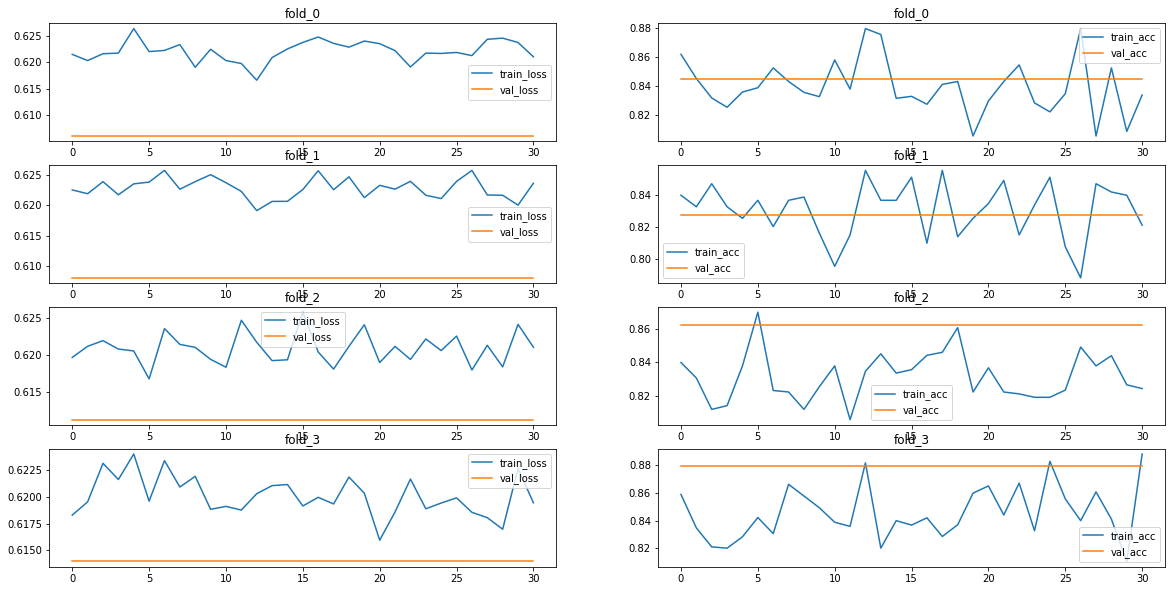

In [ ]:
fig, axes = plt.subplots(nrows=k_fold, ncols=2, figsize=(20,10))
groups = k_folds_training_stat.groupby('k_fold')
for k, group in groups:
    group[['train_loss', 'val_loss']].plot(ax=axes[k,0], title=f'fold_{k}')
    group[['train_acc', 'val_acc']].plot(ax=axes[k,1], title=f'fold_{k}')

In [ ]:
test_text = sentences
test_one_hot_labels = one_hot_encoded_y(labels)

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_input_ids, test_attention_masks = text_to_tokens(test_text, tokenizer, max_len=max_len)
test_dataloader, _ = data_loader_BERT(test_input_ids, test_attention_masks, test_one_hot_labels,  testing=True)
tokenized_texts, pred_labels, true_labels, avg_val_loss, val_acc = pred_bert_model(model, test_dataloader, label_size, class_weight=None)

100%|██████████| 232/232 [00:00<00:00, 1115.36it/s]
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.int32)
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks, dtype=torch.int32)


      Train Loss: 0.6099	 Train Acc: 0.8534	 Train F1: 0.8571	Train ovr AUC: 0.9493


In [ ]:
# result_df = pd.DataFrame(result, columns=['sentences', 'pred_label', 'true_label'])
# output = 'saved_models/prediction_' + model_path [ model_path.rfind('/')+1:model_path.rfind('.')] + '.xlsx'
# result_df.to_excel(output)
# print("result_df saved into this folder: ", output)
# print(classification_report(result_df['true_label'], result_df['pred_label']))
# print("distribution", result_df.sum())

# Prediction for Conf_Call

In [ ]:
[torch.cuda.empty_cache() for _ in range(10) ]
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  444080 KB |    1699 MB |    2016 GB |    2015 GB |
|       from large pool |  441088 KB |    1693 MB |    2009 GB |    2009 GB |
|       from small pool |    2992 KB |      10 MB |       6 GB |       6 GB |
|---------------------------------------------------------------------------|
| Active memory         |  444080 KB |    1699 MB |    2016 GB |    2015 GB |
|       from large pool |  441088 KB |    1693 MB |    2009 GB |

In [ ]:
from nltk.tokenize import sent_tokenize
sent_df = pd.read_csv("/content/drive/MyDrive/Conf_Call/language_features_tuning/all_sents_z1.txt", sep='|', nrows=None)
sent_df['text']= sent_df['text'].fillna(' .')

In [ ]:
test_text = sent_df['text']
fake_label = np.random.randint(low=0,high=label_size, size=sent_df['text'].shape[0])
test_one_hot_labels = one_hot_encoded_y(fake_label)
target_file = '/content/drive/MyDrive/Conf_Call/language_features_tuning/predict_internal_v2.csv'

In [ ]:
# batch_size = 32
# emb_dim = 768
# seq_len = max_len
# num_filters = 30
# kernel_sizes = [1,3, 5]
# num_labels = 2
# labels = ['0','1']
# class_weight = [1.0,5.0]
model_name = model_path
model = bert_lstm_cnn(embed_dim, max_len, hidden_units, num_filters, kernel_sizes, label_size, 
                                                        freeze_bert=freeze_bert, bert_embed_type=embed_type, dropout_rate=0.1)
model.load_state_dict(torch.load(model_name))
model.cuda(glovar.device_type)
get_parameter_number(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'Total': 110294018, 'Trainable': 811778}

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_input_ids, test_attention_masks = text_to_tokens(test_text, tokenizer, max_len=max_len)
test_dataloader, _ = data_loader_BERT(test_input_ids, test_attention_masks, test_one_hot_labels,  batch_size=256, testing=True) # 这里怎么加速?

100%|██████████| 6793927/6793927 [1:22:24<00:00, 1374.17it/s]
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids, dtype=torch.int32)
/content/drive/MyDrive/Conf_Call/code/5_emotion_extraction/bert_utils/data_loader.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = torch.tensor(attention_masks, dtype=torch.int32)


In [ ]:
preds = []
with torch.no_grad():
    tokenized_texts, pred_labels, true_labels, avg_val_loss, val_acc = pred_bert_model(model, test_dataloader, label_size, class_weight=None, verbose=0)
    preds.append(pred_labels[:,1])


In [ ]:
output_prob = np.concatenate(preds)
sent_df['predict'] = output_prob

In [ ]:
sent_df.to_csv(target_file) 

In [ ]:


# for cid in conf_ids[checkpoint:]:
#   result = data[data.encoded_unique_ticker_ts==cid].copy()
#   preds = []
#   for i in range(0, len(result), batch_size):
#     # get embedding
#     x, masks = get_pretrained_wordvector(result["text"].iloc[i:(i+batch_size)], tokenizer, bert_model)
#     x =  x * (masks.unsqueeze(-1).to(device))  ## 这里利用的是 broadcasting
#     x = x.to(device)

#     with torch.no_grad():
#       pred = the_model(x)
#       pred = torch.softmax(pred, dim = -1)
#       pred = pred[:,-1].detach().cpu().numpy()

#       preds.append(pred)
     
#   result["predict"] = np.concatenate(preds, axis = 0)
#   result.to_csv(target_file, header=False, index= False, mode='a')

#   checkpoint += 1

#   if checkpoint%100 ==0:
#     print("{0}: {1: .2f}".format(checkpoint, time.time()-start))

In [ ]:
i=0
import time
while True:
    i +=1
    time.sleep(2.4)
    if i % 10*4 ==1:
        print(i)